# Imports et constantes

In [1]:
from PIL import Image
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from detectron2.structures import BoxMode
import pickle
import shutil
from tqdm import tqdm

In [2]:
# constantes diverses
base_path = "./"
crops_size = 512
crops_sf = 0.5

# Génération du dataset

In [3]:
# concernant les images d'entrainement (vérité terrain)
save_path_images = "images"
imgs_names = ["S48L1-Scene-05-LAD48c2.czi.png", "S41L1-Scene-05-LAD41c2.czi.png"]
base_images = []
for img in imgs_names:
    base_images.append(Image.open(os.path.join(base_path, img)))

In [4]:
# concernant les json d'entrainement
save_path = "json"
json_names = ["S48L1-Scene-05-LAD48c2.json", "S41L1-Scene-05-LAD41c2.json"]
base_jsons = []
for jsonf in json_names:
    with open(jsonf) as json_file:
        base_jsons.append(json.load(json_file))

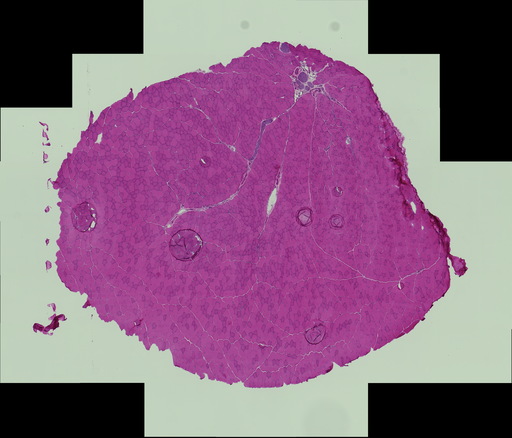

In [6]:
# redimensionnement de l'image, juste pour pouvoir la visualiser
im = base_images[0]
new_width  = 512
new_height = int(new_width * im.size[1] / im.size[0])
small_img = im.resize((new_width, new_height), Image.ANTIALIAS)
small_img

In [3]:
# fonction de découpe
# paramètres :
#   - image à découper
#   - taille (minimales) d'overlap
#   - dimensions des crops de sortie
# sortie : n images des n différents crops

def decoupage(img, size=crops_size, shift_factor=0.5):
    # définition du décalage
    shift = size * shift_factor
    # liste des crops
    crops_imgs = []
    crops_coords = []
    longueur, largeur = img.size[0], img.size[1]
    
    for i in range(int((largeur-size) / shift) + 1):
        for j in range(int((longueur - size) / shift) + 1):
            crops_imgs.append(img.crop((j * shift, i * shift, j * shift + size, i * shift + size)))
            crops_coords.append((int(j * shift), int(i * shift), int(j * shift + size), int(i * shift + size)))
            # (left, top, right, bottom)
    return crops_imgs, crops_coords

In [4]:
# renvoie les crops qui contiennent la segmentation de la fibre en question

def match_crop_segment(segment, crops_coords):
    matched_crops = []
    for crop in crops_coords:
        flag = True
        left, top, right, bottom = crop
        for coord in segment:
            # print(coord)
            x, y = coord
            belongs = (x > left) & (x < right) & (y > top) & (y < bottom)
            if not belongs:
                flag = False
                break
        if flag:
            matched_crops += [crop]
    return matched_crops

# res = match_crop_segment(ex, C)

In [5]:
def create_bbox(segment, mode="XYXY_ABS"):
    if mode == "XYXY_ABS":
        xs = np.array(segment)[:, 0]
        ys = np.array(segment)[:, 1]
        return [min(xs), min(ys), max(xs), max(ys)]

In [6]:
def change_reference(segment, crop):
    return (np.array(segment) - crop[0:2]).tolist()

In [7]:
def format_segment(segment):
    segment = segment["geometry"]["coordinates"][0]
    if len(np.array(segment).shape) > 2:
        segment = max(segment, key=len)
    return segment

In [ ]:
# Les sf sont les valeurs de shift factor : le shift factor permet de calculer le décallage lors de
# la génération des crops : décallage = taille coté image * shift factor
# Il faut le choisir judicieusement pour ne pas se retrouver avec des cellules présentes entierement
# sur aucun crop

for sf in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    imgs, coords = decoupage(base_images[0], shift_factor=sf)
    matched_semgents = []
    for segment in base_jsons[0]["features"]:
        matchs = match_crop_segment(format_segment(segment), coords)
        matched_semgents.append(len(matchs))
    dict_res = dict((x, matched_semgents.count(x)) for x in set(matched_semgents))
    print(f"With shift factor = {sf}")
    print("(Présence d'une cellules sur N images): (Nombre M de cellules concernées)")
    print(dict_res)
    print("-------------------------------------------------------------------------")



In [ ]:
# génère les images de crops et crée une bdd de ces images de crops avec leurs coordonnées dans l'image de base

bdd = {}
for i, base_img in enumerate(base_images):
    crops_imgs, crops_coords = decoupage(base_img, size=crops_size, shift_factor=crops_sf)
    for j, img in enumerate(crops_imgs):
        img.save(os.path.join(base_path, save_path_images, f"{imgs_names[i].split('.')[0]}_{j}.jpg"))    
        bdd[f"{imgs_names[i].split('.')[0]}_{j}.jpg"] = {"segments": [], "bboxes": [], "labels": [], "coords": crops_coords[j]}
    
    for features in base_jsons[i]["features"]: # parcours des segments
        segment = format_segment(features)
        matchs = match_crop_segment(segment, crops_coords)
        for crop in matchs: # parcours des images contenant le segment
            img_idx = crops_coords.index(crop)
            new_segment = change_reference(segment, crop)
            img_name = f"{imgs_names[i].split('.')[0]}_{img_idx}.jpg"
            bdd[img_name]["segments"].append(new_segment)
            bdd[img_name]["bboxes"].append(create_bbox(new_segment))
            bdd[img_name]["labels"].append(features["properties"]["classification"]["name"])

In [8]:
# fonction pour apposer des bboxes à une image

def draw_bounding_box(img, rect_coordinates, labels):
    colors = ["r" if x == "Fast" else "b" for x in labels]
    # Show bounding boxes
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(img)
    # Create a Rectangle patch
    for i, e in enumerate(rect_coordinates):
        (x0, y0, x1, y1) = e
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=1, edgecolor=colors[i], facecolor='none')
        ax.add_patch(rect)
    plt.figure(figsize=(8, 8))
    plt.show()

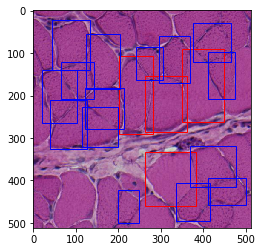

<Figure size 576x576 with 0 Axes>

In [19]:
# On teste l'affichage d'une image avec ses annotations pour vérifier le bon fonctionnement

nametest = "S48L1-Scene-05-LAD48c2_600.jpg"
imtest = Image.open(os.path.join(base_path, "images", nametest))
rectstest = bdd[nametest]["bboxes"]
labelstest = bdd[nametest]["labels"]
draw_bounding_box(np.array(imtest), rectstest, labelstest)

In [9]:
# cette fonction permet de convertir notre base de données en un dataset convenant à la libraire detectron

def construct_detectron_dataset(base_dataset, path_imgs_folder, size=crops_size):
    dataset = []
    for img in base_dataset:
        img_obj = base_dataset[img]
        annotations = []
        for i in range(len(img_obj["labels"])):
            new_annot = {
                "iscrowd": 0,
                "segmentation": [np.array(img_obj["segments"][i]).flatten().tolist()],
                "bbox": img_obj["bboxes"][i],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0 if img_obj["labels"][i] == "Slow" else 1
            }
            annotations.append(new_annot)
        new_obj = {
            "file_name": os.path.join(path_imgs_folder, img),
            "image_id": img.split(".")[0],
            "height": size,
            "width": size,
            "annotations": annotations,
            "base_coords": img_obj["coords"]
        }
        dataset.append(new_obj)
    return dataset

In [ ]:
dataset = construct_detectron_dataset(bdd, save_path_images)

In [10]:
# sauvegarder le dataset

with open("dataset.pkl", "wb") as file:
    pickle.dump(dataset, file, pickle.HIGHEST_PROTOCOL)

# Training

## Chargement du dataset

In [338]:
import torch, detectron2

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from PIL import Image
import matplotlib.pyplot as plt
import pickle
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from sklearn.model_selection import train_test_split

In [339]:
with open('dataset.pkl', "rb") as file:
    dataset = pickle.load(file)

In [340]:
# fonctions de split du dataset complet en un trainset et un testset

def get_dataset():
    with open('dataset.pkl', "rb") as file:
        ds = pickle.load(file)
    trainset, valset = train_test_split(ds, test_size=0.25, random_state=0)
    return trainset, valset

def get_trainset():
    return get_dataset()[0]

def get_valset():
    return get_dataset()[1]

In [341]:
DatasetCatalog.register("trainset", get_trainset)
DatasetCatalog.register("valset", get_valset)

In [342]:
trainset = DatasetCatalog.get("trainset")
MetadataCatalog.get("trainset").set(thing_classes=["Slow", "Fast"])
valset = DatasetCatalog.get("valset")
MetadataCatalog.get("valset").set(thing_classes=["Slow", "Fast"])
metadata = MetadataCatalog.get("trainset")

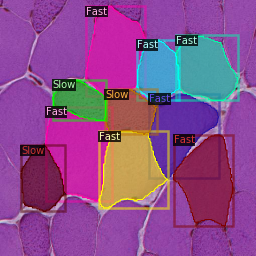

In [347]:
dataset_dicts = dataset
d = random.sample(dataset_dicts, 1)[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
im = Image.fromarray(out.get_image()[:, :, ::-1])
im

## Entrainement de Mask-RCNN

In [16]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# sélection de GPU
%env CUDA_VISIBLE_DEVICES=0

/bin/bash: nvcc : commande introuvable
torch:  1.11 ; cuda:  cu102
detectron2: 0.6
env: CUDA_VISIBLE_DEVICES=0


In [365]:
# Personnalisation de la configuration

def custom_config(num_classes):
    cfg = get_cfg()
    # get configuration from model_zoo
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    # Model
    cfg.MODEL.MASK_ON = True
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
#     cfg.MODEL.BACKBONE.NAME = "build_resnet_backbone"
#     cfg.MODEL.RESNETS.DEPTH = 34
    # Solver
#     cfg.SOLVER.BASE_LR = 0.0002
    cfg.SOLVER.MAX_ITER = 400
#     cfg.SOLVER.STEPS = (20, 10000, 20000)
#     cfg.SOLVER.gamma = 0.5
    cfg.SOLVER.IMS_PER_BATCH = 2
    # Test
#     cfg.TEST.DETECTIONS_PER_IMAGE = 20
    # INPUT
#     cfg.INPUT.MIN_SIZE_TRAIN = (800,)
    # DATASETS
    cfg.DATASETS.TEST = ()
    cfg.DATASETS.TRAIN = ('trainset',)
    # DATASETS
#     cfg.OUTPUT_DIR = "your local path"
    cfg.SOLVER.IMS_PER_BATCH = 4
#     cfg.TEST.EVAL_PERIOD = 100
#####################################################
#     cfg.MODEL.RPN.POSITIVE_FRACTION = 0.9 # 0.5
    cfg.SOLVER.BASE_LR = 0.005

    return cfg

In [366]:
cfg = custom_config(2) # 2 classes : Slow (0) & Fast (1)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/25 14:50:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/25 14:51:00 d2.data.build]: Removed 961 images with no usable annotations. 969 images left.
[05/25 14:51:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/25 14:51:00 d2.data.build]: Using training sampler TrainingSampler
[05/25 14:51:00 d2.data.common]: Serializing 969 elements to byte tensors and concatenating them all ...
[05/25 14:51:01 d2.data.common]: Serialized dataset takes 23.04 MiB
WARNING [05/25 14:51:01 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[05/25 14:51:02 d2.engine.train_loop]: Starting training from iteration 0
[05/25 14:51:16 d2.utils.events]:  eta: 0:03:15  iter: 19  total_loss: 2.452  loss_cls: 0.7941  loss_box_reg: 0.7487  loss_mask: 0.6826  loss_rpn_cls: 0.09432  loss_rpn_loc: 0.07336  time: 0.5175  data_time: 0.2265  lr: 0.00024226  max_mem: 6692M
[05/25 14:51:27 d2.utils.events]:  eta: 0:03:08  iter: 39  total_loss: 1.997  loss_cls: 0.542  loss_box_reg: 0.7042  loss_mask: 0.4696  loss_rpn_cls: 0.1413  loss_rpn_loc: 0.1187  time: 0.5217  data_time: 0.0299  lr: 0.00049201  max_mem: 6692M
[05/25 14:51:37 d2.utils.events]:  eta: 0:02:56  iter: 59  total_loss: 1.218  loss_cls: 0.3521  loss_box_reg: 0.506  loss_mask: 0.2061  loss_rpn_cls: 0.06109  loss_rpn_loc: 0.04358  time: 0.5209  data_time: 0.0292  lr: 0.00074176  max_mem: 6692M
[05/25 14:51:47 d2.utils.events]:  eta: 0:02:44  iter: 79  total_loss: 0.7228  loss_cls: 0.2541  loss_box_reg: 0.2488  loss_mask: 0.1245  loss_rpn_cls: 0.03225  loss_rpn_loc: 0.03413  time:

## Validation du réseau entrainé

In [367]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [368]:
def save_last_model_and_metrics(name, metrics, cfg):
    os.mkdir(os.path.join("models", name))
    shutil.copyfile("output/model_final.pth", os.path.join("models", name, "model.pth"))
    with open(os.path.join("models", name, "eval.txt"),"a+") as f:
        f.write(str(metrics))
    with open(os.path.join("models", name, "cfg.txt"),"a+") as f:
        f.write(str(cfg))

In [369]:
cfg = custom_config(2)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set a custom testing threshold (base : 'SCORE_THRESH_TEST': 0.05)
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("valset", ("bbox", "segm"), False, output_dir="./evaluations")
val_loader = build_detection_test_loader(cfg, "valset")
eval_res = inference_on_dataset(predictor.model, val_loader, evaluator)

[05/25 14:56:34 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

[05/25 14:56:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/25 14:56:37 d2.data.common]: Serializing 644 elements to byte tensors and concatenating them all ...
[05/25 14:56:37 d2.data.common]: Serialized dataset takes 8.17 MiB
[05/25 14:56:37 d2.evaluation.evaluator]: Start inference on 644 batches
[05/25 14:56:42 d2.evaluation.evaluator]: Inference done 11/644. Dataloading: 0.0027 s/iter. Inference: 0.0483 s/iter. Eval: 0.0124 s/iter. Total: 0.0635 s/iter. ETA=0:00:40
[05/25 14:56:47 d2.evaluation.evaluator]: Inference done 98/644. Dataloading: 0.0036 s/iter. Inference: 0.0448 s/iter. Eval: 0.0095 s/iter. Total: 0.0582 s/iter. ETA=0:00:31
[05/25 14:56:52 d2.evaluation.evaluator]: Inference done 182/644. Dataloading: 0.0036 s/iter. Inference: 0.0449 s/iter. Eval: 0.0101 s/iter. Total: 0.0588 s/iter. ETA=0:00:27
[05/25 14:56:57 d2.evaluation.evaluator]: Inference d

In [370]:
# sauvegarder le modèle et ses performances de validation
save_last_model_and_metrics("modele_base_400_epochs_lr_0005", eval_res, cfg)

In [353]:
eval_res

OrderedDict([('bbox',
              {'AP': 76.39210324289635,
               'AP50': 90.24957611394274,
               'AP75': 88.69790611371602,
               'APs': 5.221888260254597,
               'APm': 78.91757527899537,
               'APl': 75.43213781032486,
               'AP-Slow': 76.39502029923388,
               'AP-Fast': 76.38918618655882}),
             ('segm',
              {'AP': 82.94622249474295,
               'AP50': 90.17923934734289,
               'AP75': 89.28627234715746,
               'APs': 2.736246866374617,
               'APm': 79.37728678732053,
               'APl': 87.58843670383163,
               'AP-Slow': 82.92010538893881,
               'AP-Fast': 82.9723396005471})])

[05/25 13:51:16 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

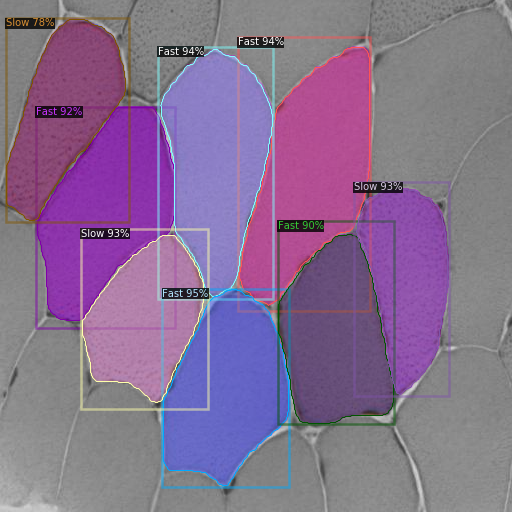

In [305]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
d = random.sample(valset, 1)[0]
im = cv2.imread(d["file_name"])
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=metadata, 
               scale=1, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
im = Image.fromarray(out.get_image()[:, :, ::-1])
im

## Test du réseau entrainé

In [314]:
def iou_segms(segm1, segm2):
    segm1 = np.array(segm1)
    segm2 = np.array(segm2)
    xmin = min(min(segm1[:, 0]), min(segm2[:, 0]))
    ymin = min(min(segm1[:, 1]), min(segm2[:, 1]))
    xmax = max(max(segm1[:, 0]), max(segm2[:, 0]))
    ymax = max(max(segm1[:, 1]), max(segm2[:, 1]))
    segm1 -= [xmin, ymin]
    segm2 -= [xmin, ymin]
    canvas1 = np.zeros((ymax - ymin, xmax - xmin))
    canvas2 = np.zeros((ymax - ymin, xmax - xmin))
    mask1 = cv2.drawContours(canvas1, [segm1], -1, 1, cv2.FILLED)
    mask2 = cv2.drawContours(canvas2, [segm2], -1, 1, cv2.FILLED)
    sum_masks = (mask1 + mask2).flatten()
    i = sum(sum_masks == 2)
    u = sum(sum_masks >= 1)
    iou = i / u
    return iou

In [315]:
def nms_pytorch(bboxes, segms, scores, classes, thresh_iou, segms_thresh_iou=None):
    bboxes = torch.column_stack((bboxes, torch.tensor(range(bboxes.shape[0])).to("cuda")))

    # we extract coordinates for every
    # prediction box present in bboxes
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    # calculate area of every block in bboxes
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in bboxes
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for
    # filtered prediction boxes
    keep = []

    while len(order) > 0:

        # extract the index of the
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(bboxes[idx])

        # remove S from bboxes
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break

        # select coordinates of BBoxes according to
        # the indices in order
        xx1 = torch.index_select(x1, dim=0, index=order)
        xx2 = torch.index_select(x2, dim=0, index=order)
        yy1 = torch.index_select(y1, dim=0, index=order)
        yy2 = torch.index_select(y2, dim=0, index=order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1

        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w * h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim=0, index=order)

        # find the union of every prediction T in bboxes
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]

        # find the IoU of every prediction in bboxes with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
    
        
        # NMS refinement with using instance segmentations
        if segms_thresh_iou: 
            for i, val in enumerate(mask):
                if not val:
                    segms_IoU = iou_segms(segms[idx], segms[order[i]])
                    mask[i] = torch.tensor(segms_IoU < segms_thresh_iou)
        
        order = order[mask]
    
    keep = torch.vstack(keep)
    
    sel_ind = keep[:, 4]
    sel_ind = sel_ind.cpu().numpy().astype("int32")
    
    bboxes = keep[:, 0:4].cpu().numpy().astype("int32").tolist()
    segms = [segms[i] for i in sel_ind]
    scores = scores[sel_ind].cpu().tolist()
    classes = classes[sel_ind].cpu().numpy().astype("int32").tolist()
    
    return bboxes, segms, scores, classes

In [312]:
# concernant les images d'entrainement (vérité terrain)
save_path_crops = "test_crops"
test_img_name = "S48L1-Scene-04-LAD48c1.png"
test_img = Image.open(os.path.join(base_path, test_img_name))

In [313]:
bdd = {}

crops_imgs, crops_coords = decoupage(test_img, size=crops_size, shift_factor=crops_sf)
for i, img in enumerate(crops_imgs):
    img.save(os.path.join(base_path, save_path_crops, f"{test_img_name.split('.')[0]}_{i}.jpg"))    
    bdd[f"{test_img_name.split('.')[0]}_{i}.jpg"] = {"segments": [], "bboxes": [], "labels": [], "coords": crops_coords[i]}

In [316]:
dataset = construct_detectron_dataset(bdd, save_path_crops)

In [329]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2 # set a custom testing threshold (base : 'SCORE_THRESH_TEST': 0.05)
# predictor = DefaultPredictor(cfg)

# all_bboxes = torch.tensor([]).to("cuda")
# all_scores = torch.tensor([]).to("cuda")
# all_classes = torch.tensor([]).to("cuda")
# all_segms = []

# for crop in tqdm(dataset):
#     im = cv2.imread(crop["file_name"])
#     coords = crop["base_coords"]
#     new_ref = torch.tensor([coords[0], coords[1], coords[0], coords[1]]).to("cuda")
#     outputs = predictor(im)
#     instances = outputs["instances"]
#     all_bboxes = torch.concat([all_bboxes, (instances.pred_boxes.tensor + new_ref)])
#     all_scores = torch.concat([all_scores, instances.scores])
#     all_classes = torch.concat([all_classes, instances.pred_classes])
#     for mask in outputs["instances"].pred_masks:
#         mask = (mask.cpu().numpy() * 1).astype(np.uint8)
#         contours = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[1][0][:, 0, :]
#         all_segms.append((contours + coords[0:2]).tolist())
    
bboxes, segms, scores, classes = nms_pytorch(all_bboxes, all_segms, all_scores, all_classes, 0.99)

In [330]:
len(bboxes)

15410

In [331]:
def save_img_with_bounding_box(img, rect_coordinates, segms_coordinates, labels):
    img = np.array(img)
    colors = [(0, 0, 255) if x == 1 else (255, 0, 0) for x in labels]
#     for i, rect in enumerate(rect_coordinates):
#         cv2.rectangle(img, tuple(rect[0:2]),  tuple(rect[2:4]), colors[i], 3) # thick
    
    for i, segm in enumerate(segms_coordinates):
        cv2.drawContours(img, [np.array(segm)], -1, colors[i], cv2.FILLED)    
    
    cv2.imwrite("my_plot_no_nms.png", img)


save_img_with_bounding_box(test_img, bboxes, segms, classes)

# Annexes

In [91]:
# a finir un jour : re-scaling des masques
outputs["instances"][0].pred_masks
base = torch.zeros((1, 10240, 8768)).bool()
d["base_coords"]
base[0, 3328:3840, 2816:3328] = outputs["instances"][0].pred_masks